# Python example of parsing a Turtle file and working with RDF graphs.
paper: Building Metadata Normalization Using Generative AI


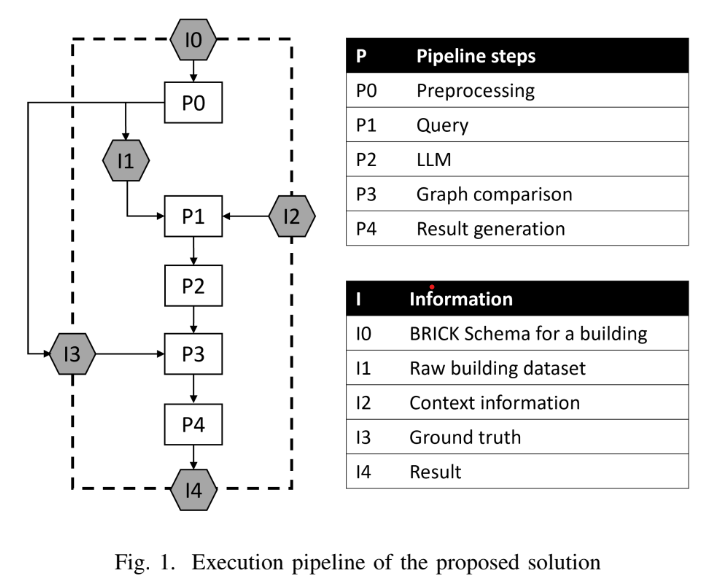

## P0: Preprocessing

Especially with the open-source LLMs there is a limitation on the input/output token limit. 
Thereby, we needed to pre-process the prepared BRICK schema for the building (I0). 
To accomplish this we extracted the raw metadata names from the turtle files.
This can be done by parsing the turtle files and filtering the resulting Resource Description Framework (RDF) graph with the type relationships. 
This way we get all the raw metadata names together with their classes.


In [14]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF
import random

# Define namespaces
BRICK = Namespace("https://brickschema.org/schema/1.1/BRICK#")
EX = Namespace("http://example.org/building#")


In [ ]:
# extract all data to text format

file_path = "building_data2.ttl"
output_file = "raw_building_data.txt"
# Load Turtle file into an RDF graph
g = Graph()
g.parse(file_path, format="turtle")


# Bind namespaces for better output readability
g.bind("brick", BRICK)
g.bind("ex", EX)
g.bind("rdf", RDF)

def extract_raw_identifiers(graph):
    """
    Extracts raw identifiers from the Turtle file and returns them as a flat list.
    """
 
    
    # Collect all unique terms from the triples
    raw_identifiers = set()
    for subject, predicate, obj in graph:
        for term in (subject, obj):
            if isinstance(term, URIRef):
                # Extract only the local part of the URI (e.g., "AHU1")
                raw_identifiers.add(term.split('/')[-1])
            elif isinstance(term, Literal):
                # Add literals directly (if they are identifiers)
                raw_identifiers.add(str(term))
    
    # Convert the set to a sorted list for readability
    return sorted(raw_identifiers)

def save_raw_data_to_file(data, output_file):
    """
    Saves the raw identifiers as a comma-separated string to a text file.
    """
    with open(output_file, "w") as f:
        f.write(", ".join(data))

# Extract raw identifiers
raw_data = extract_raw_identifiers(g)

# Save to output file
save_raw_data_to_file(raw_data, output_file)

print(f"Raw building data has been saved to {output_file}")

Raw building data has been saved to raw_building_data.txt


In [3]:
# Query to extract all nodes and their types
print("Nodes and their types:")
for subject, rdf_type in g.subject_objects(predicate=RDF.type):  # Use RDF.type for clarity
    print(f"{subject} is of type {rdf_type}")


Nodes and their types:
http://example.org/building#MainOfficeBuilding is of type https://brickschema.org/schema/1.1/Brick#Building
http://example.org/building#FirstFloor is of type https://brickschema.org/schema/1.1/Brick#Floor
http://example.org/building#SecondFloor is of type https://brickschema.org/schema/1.1/Brick#Floor
http://example.org/building#ConferenceRoomA is of type https://brickschema.org/schema/1.1/Brick#Room
http://example.org/building#Office101 is of type https://brickschema.org/schema/1.1/Brick#Room
http://example.org/building#ServerRoom is of type https://brickschema.org/schema/1.1/Brick#Room
http://example.org/building#ConferenceRoomA_Lighting is of type https://brickschema.org/schema/1.1/Brick#Lighting_System
http://example.org/building#Office101_Lighting is of type https://brickschema.org/schema/1.1/Brick#Lighting_System
http://example.org/building#CeilingLight1 is of type https://brickschema.org/schema/1.1/Brick#Light_Fixture
http://example.org/building#CeilingLig

Thereby, we take n number of points from total points v and query the RDF graph for their neighbours with all the relation types and the neighbours of queried neighbors for only type relationships. 
We only need type relationships of neighbors of neighbors as we also record them as raw metadata points.

In [4]:

# Step 1: Select `n` random points (subjects) from the graph
def get_random_subjects(graph, n):
    subjects = list(set(graph.subjects()))
    if len(subjects) < n:
        n = len(subjects)  # Prevent sampling more than available
    return random.sample(subjects, n)

In [5]:
# Step 2: Query the graph for direct neighbors and their relation types
def get_neighbors_with_relations(graph, subject):
    neighbors = []
    for predicate, obj in graph.predicate_objects(subject):
        neighbors.append((predicate, obj))  # Store the relation and object
    return neighbors

In [6]:
# Step 3: Get type relationships of neighbors' neighbors
def get_type_relationships(graph, neighbors):
    type_relations = {}
    
    for pred, neighbor in neighbors:  # Iterate over neighbors
        if neighbor not in type_relations:
            type_relations[neighbor] = []
        
        # Check all triples for the neighbor
        for pred2, obj2 in graph.predicate_objects(neighbor):
            if pred2 == RDF.type:  # Only consider rdf:type relationships
                type_relations[neighbor].append((pred2, obj2))
    
    return type_relations


In [ ]:
# Step 4: Extract metadata
def extract_metadata(graph, n_points):
    # Get random points
    #random_points = get_random_subjects(graph, n_points)
    #metadata = {}

    #for point in random_points:
        #print(f"Processing point: {point}")  # Debugging
        #neighbors = get_neighbors_with_relations(graph, point)
        #print(f"  Neighbors: {neighbors}")  # Debugging
        
        # Query type relationships of neighbors' neighbors
        #type_rels = get_type_relationships(graph, neighbors)
        #print(f"  Type relationships: {type_rels}")  # Debugging
        
        #metadata[point] = type_rels
    
    #print("test1", metadata)
    
    #return metadata
    """
    Extracts metadata and returns it as a comma-separated string of terms.
    """
    # Get random points
    random_points = get_random_subjects(graph, n_points)
    all_terms = set()  # Use a set to avoid duplicates

    for point in random_points:
        # Get neighbors and their relationships
        neighbors = get_neighbors_with_relations(graph, point)
        
        # Query type relationships of neighbors' neighbors
        type_rels = get_type_relationships(graph, neighbors)
        
        # Collect terms from points, neighbors, and their relationships
        all_terms.add(str(point))
        all_terms.update(neighbors)
        for rel in type_rels.values():
            all_terms.update(rel)
    
    # Convert the set of terms into a sorted list
    sorted_terms = sorted(all_terms)
    
    # Join the terms into a comma-separated string
    metadata_string = ", ".join(sorted_terms)
    
    return metadata_stringmeta

In [17]:
#Modify the metadata to replace empty lists with a meaningful message:

def post_process_metadata(metadata):
    # Handle if metadata is a tuple
    if isinstance(metadata, tuple):
        # Example: unpack tuple
        try:
            metadata = dict(metadata)  # Attempt to convert to dictionary
        except (ValueError, TypeError):
            raise ValueError("Input metadata must be a dictionary or convertible to one.")

    if not isinstance(metadata, dict):
        raise TypeError(f"Expected metadata to be a dictionary, got {type(metadata).__name__}")

    for neighbor, relationships in metadata.items():
        if not relationships:
            metadata[neighbor] = "No rdf:type relationships found"
    return metadata


In [18]:
#Save the processed metadata for further use:
import json

# Save metadata to a JSON file
def save_metadata_to_file(metadata, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(metadata, json_file, indent=4, default=str)
    print(f"Metadata saved to {file_path}")

In [22]:
# Define the number of points to query
n_points = 5  # Adjust the number as needed

# Extract metadata
metadata_points = extract_metadata(g, n_points)

# Post-process to replace empty lists
#processed_metadata = post_process_metadata(metadata_points)
save_raw_data_to_file(metadata_points, output_file)

# Save the metadata
#output_file = "extracted_metadata.json"
#save_metadata_to_file(processed_metadata, output_file)

# Print final processed metadata
print("Final Processed Metadata:")
#print(json.dumps(processed_metadata, indent=4, default=str))

TypeError: '<' not supported between instances of 'tuple' and 'str'

In [12]:

# Display or save the metadata
import json
print("Extracted Metadata:")
print(json.dumps(metadata_points, indent=4, default=str))

Extracted Metadata:
{
    "http://example.org/building#Office101_Lighting": {
        "https://brickschema.org/schema/1.1/Brick#Lighting_System": [],
        "http://example.org/building#DeskLight1": [
            [
                "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
                "https://brickschema.org/schema/1.1/Brick#Light_Fixture"
            ]
        ]
    },
    "http://example.org/building#TempSensor_A": {
        "https://brickschema.org/schema/1.1/Brick#Temperature_Sensor": []
    },
    "http://example.org/building#MainOfficeBuilding": {
        "https://brickschema.org/schema/1.1/Brick#Building": [],
        "http://example.org/building#FirstFloor": [
            [
                "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
                "https://brickschema.org/schema/1.1/Brick#Floor"
            ]
        ],
        "http://example.org/building#SecondFloor": [
            [
                "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    

## Query (P1)
With the raw building dataset and or context information
(I2) at hand, we construct a query. This query is designed
to provide the required information to LLMs to generate the
specific output.

In [ ]:
import openai
def convert_raw_data_to_brick(raw_data, openai_api_key):
    """
    Uses OpenAI's GPT-4 to convert raw metadata into Brick schema.
    """
    # Define the prompt
    prompt = f"""
You are an assistant knowledgeable about Brick schema (https://brickschema.org). Convert the following raw metadata into a Brick schema representation in Turtle (TTL) format.

Raw Metadata:
{raw_data}

The Brick schema output should represent these entities and relationships in a structured manner.
    """

    # Call OpenAI's GPT-4 API
    openai.api_key = openai_api_key
    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert in Brick schema and RDF data modeling."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.2,  # Low temperature for deterministic output
    )
    
    # Extract the response content
    return response['choices'][0]['message']['content']

def main():
    # Input: Raw metadata
    raw_metadata = """
    Brick#Building, Brick#Cooling_System, Brick#Floor, Brick#HVAC_Zone, Brick#Light_Fixture, Brick#Lighting_System,
    Brick#Room, Brick#Temperature_Sensor, Brick#Thermostat, building#CeilingLight1, building#CeilingLight2,
    building#ConferenceRoomA, building#ConferenceRoomA_HVAC, building#ConferenceRoomA_Lighting, building#DeskLight1,
    building#FirstFloor, building#MainOfficeBuilding, building#Office101, building#Office101_Lighting,
    building#SecondFloor, building#ServerRoom, building#ServerRoom_Cooling, building#ServerRoom_TempSensor,
    building#TempSensor_A, building#Thermostat_A
    """

    # OpenAI API Key
    openai_api_key = "***"  # Replace with OpenAI API key

    # Convert raw data to Brick schema
    brick_schema_output = convert_raw_data_to_brick(raw_metadata, openai_api_key)

    # Save the result to a Turtle file
    output_file = "brick_schema_output.ttl"
    with open(output_file, "w") as f:
        f.write(brick_schema_output)
    
    print(f"Brick schema has been saved to {output_file}")
